# Machine Learning

ARDS or [Acute respiratory distress syndrome](https://www.uptodate.com/contents/acute-respiratory-distress-syndrome-clinical-features-diagnosis-and-complications-in-adults) is a difficult disease both to define and also to predict. The definition of ARDS we will be using is the Berlin Criteria (Lung imaging shows Bilateral Infiltrates and PaO2/FiO2 is < 300). We are going to design and train an algorithm to predict the onset of ARDS before it occurs as best you can using the limited data in this sample dataset. The target labels are provided for you for each patient encounter.

## Introduction to the Sample Dataset

This sample dataset is a subset taken from a freely accessible critical care database. `berlin_ards` above is a dictionary of patient encounters. An encounter is one hospitalization. One patient can have multiple admissions to the hospital. Each admission would have a unique encounter_ID. In this dataset the times have been modified but the time intervals are real. 

In [62]:
import os, sys, time, re, random, math, json
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datetime import datetime
from numpy import interp
from datetime import datetime
from sklearn.model_selection import train_test_split
import numpy as np
import random
import os
random_state = np.random.RandomState(42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc 
#Choose from any scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,  make_scorer, precision_score, recall_score, \
average_precision_score, accuracy_score, average_precision_score
from sklearn.metrics import roc_curve, auc  , precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import random
import seaborn as sns
#Scale the data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# # apply same transformation to test data
# X_test = scaler.transform(X_test)
from sklearn import metrics
from scipy.stats import ks_2samp
import numpy as np
from datetime import datetime
import pandas as pd
from sklearn.pipeline import Pipeline as nosampling_pipeline

import seaborn as sn
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
print(sys.version)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]


## Load the Sample Dataset


In [63]:
with open('berlin_ards.json') as json_file:
    berlin_ards = json.load(json_file)

In [64]:
keys = list(berlin_ards.keys())
num_encs = len(keys)
print("There are {} patient encounters in this dataset".format(num_encs))

There are 8709 patient encounters in this dataset


In [65]:
print("{} is an example of an encounter ID".format(keys[0]))

200021 is an example of an encounter ID


plug the encounter ID into the dictionary to see information about this patient's encounter

here is some basic information about this hospitalization and all the keys to the other types of data for this encounter

In [66]:
enc = berlin_ards[keys[0]]
#enc = berlin_ards['282407']
print('')
print(keys[0])
print(enc['Info'])
enc.keys()


200021
{'age': 60.0, 'gender': 'M', 'weight': 82.6, 'subject_id': '61691', 'is_in_hospital_death': False, 'is_Berlin_ARDS': False, 'first_measurement_time': '2114-12-26T20:40:00', 'is_Berlin_time': '2114-12-26T21:23:00', 'last_measurement_time': '2114-12-27T22:00:00'}


dict_keys(['Info', 'feature_matrix_row_names', 'feature_sampling_interval_minutes', 'feature_matrix'])


We have a feature matrix of timeseries features where each row is a different vital sign or lab measurement and each column is a different timestep starting with column 0 = time zero.  

As an example, here are the first 24 hours of oxygen saturation (SpO2) measurements. The first SpO2 measurement was made 60 minutes into the stay, which is why the first 2 columns are not a number

In [67]:
print(enc['feature_matrix_row_names'])
period = enc['feature_sampling_interval_minutes']
print('number of features', len(enc['feature_matrix_row_names']))
print('minutes between timesteps', period)
feature_index = 0
print(enc['feature_matrix_row_names'][feature_index])
feature_matrix = np.array(enc['feature_matrix'])
print(feature_matrix[feature_index,:int(12*60/period)])
print(feature_matrix.shape)

['SysABP', 'DiasABP', 'HR', 'Temp', 'RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets']
number of features 9
minutes between timesteps 30
SysABP
[ nan 103. 103. 106.  94.  90.  90.  96.  96.  92.  92. 101. 101. 124.
 124. 124. 124. 125. 125. 126. 126. 125. 125. 122.]
(9, 51)


## Checking if all the feature values are available during each hospital encounter
Observation 1:Duration of stays during each encounter are not the same as indicated by the different shapes of the feature matrix during each encounter.

Observation 2: All features were not avialable at the same time. Some feature values are missing.

In order to study the distributions of the features, they first should be normalized by the duration i.e the first 12 hours, the first 24 hours, first 48 hours.


when considering distribution of features, we have to consider the values of encounters at a specific time point after admission of patients or the average of those values. In some cases, we may not have the value at a specific time instant .e.g. 12 hours. So in those scenarios, we have to consider an imputed value. In the clinical world, this is not a reliable method to impune as the values can change or can have a completely different value. It is safe to use mean or median values of available data

### Sanity Check

The length of stay should be within one period of the amount of time represented by the feature matrix

In [68]:
start_time = datetime.strptime(enc['Info']['first_measurement_time'], '%Y-%m-%dT%H:%M:%S')
stop_time = datetime.strptime(enc['Info']['last_measurement_time'], '%Y-%m-%dT%H:%M:%S')

lenofstay_mins = (stop_time - start_time).total_seconds()/60
print(int(lenofstay_mins/60), 'hours', feature_matrix.shape[1]*period/60, 'hours')

25 hours 25.5 hours


# Exploring the Data

For the 3 features: 

    a. Systolic Blood Pressure (SysABP)

    b. Temperature (Temp) 

    c. White Blood Cell Count (WBC)
   

In [69]:
from multiprocess import Pool
import pandas as pd
import seaborn as sbn

feature_index = 0
def distribution_plot(keys,feature_index, berlin_ards):
    from multiprocess import Pool
    import pandas as pd
    import seaborn as sbn
    import numpy as np
    import matplotlib.pyplot as plt
    feature_data = []
    for k in keys:
        enc = berlin_ards[k]
        ## first 24 hours distribution
        N = 48 # to account for N/2 hours in 30 minutes sampling period
        # to ensure only those encounters that have lasted for atleast 12 hours 
        if np.array(enc['feature_matrix']).shape[1] >=N:

            feature_data.append(np.nanmean(np.array(enc['feature_matrix'][feature_index][:N-1])))
    feature_data = np.array(feature_data)
    feature_data = feature_data[~np.isnan(feature_data)]    ## only the real values of systole
    return feature_data


inputs = [(keys,i, berlin_ards) for i in [0, 3,7]]
if __name__ == '__main__':
    with Pool(8) as p:
        results = p.starmap(distribution_plot, inputs)


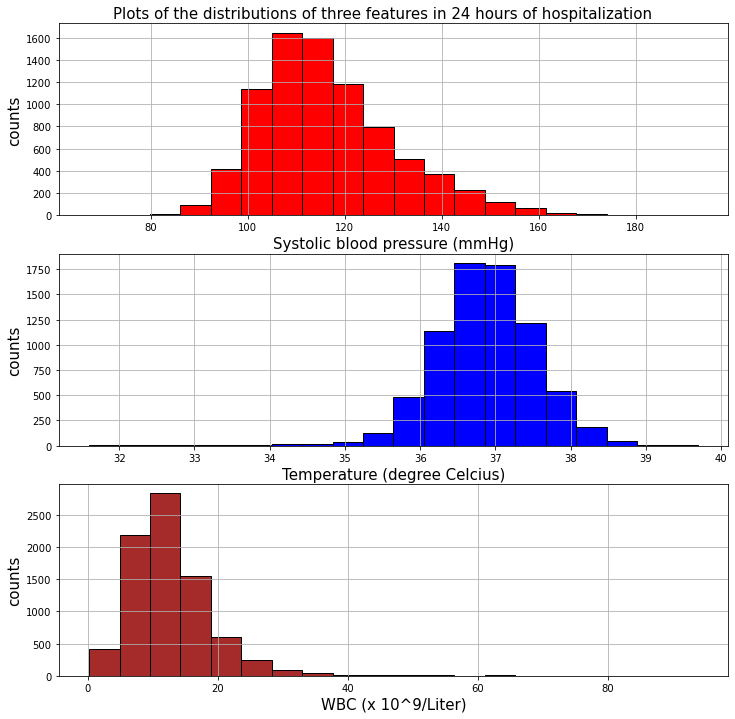

In [70]:
### Distribution plots
features =['Systolic blood pressure', 'Temperature' , 'WBC']
Units =['mmHg', 'degree Celcius', 'x 10^9/Liter']
colors = ['red', 'blue', 'brown']
plt.figure(figsize=(12,12))
plt.suptitle('Plots of the distributions of three features in 24 hours of hospitalization', y =0.9, fontsize =15)
for i, f, u, c in zip(range(len(results)), features, Units, colors):
    plt.subplot(3,1,i+1)
    w =  2
    data = results[i]
    bins =np.arange(min(data), max(data) + w, w) 
    plt.hist(results[i], color= colors[i], bins =20, edgecolor="black")
    plt.xlabel(features[i] + ' (' + u + ')', fontsize =15)
    plt.ylabel('counts', fontsize =15)
    plt.grid(True)
plt.savefig('Feature_distribution_plot.png', dpi= 300) 

#### Checking the normal (with ARDS) physiological ranges
1. Systolic bllod pressure:
    - Normal	systolic: less than 120 mm Hg
    - At Risk (prehypertension)	systolic: 120–139 mm Hg
    - High Blood Pressure (hypertension)	systolic: 140 mm Hg or higher4
 
[1] https://www.cdc.gov/bloodpressure/about.htm

Comments: The values are within the physiological range as advised 

2. Temperature

    - Normal: 36.5–37.5 °C (97.7–99.5 °F)
    - Fever: >37.5 or 38.3 °C (99.5 or 100.9 °F)

[2] https://www.webmd.com/first-aid/normal-body-temperature

3. White blood cell counts

    - The normal number of WBCs in the blood is 4,500 to 11,000 WBCs per microliter (4.5 to 11.0 × 10^9/Liter).

[3] https://www.ucsfhealth.org/medical-tests/003643

Comments: There are some count values that are very high range 


#### Units used in features

1. Systlolic blood pressure unit: mmHg

2. Temperature unit : degree celcius

3. WBC counts unit : numbers per litre of blood


In [71]:
encounter_index = 1
print('Did this patient develope ARDS according to the Berlin Criteria?',
      berlin_ards[keys[encounter_index]]['Info']['is_Berlin_ARDS'])
print('Time Berlin Criteria was evaluated',
      berlin_ards[keys[encounter_index]]['Info']['is_Berlin_time'])

Did this patient develope ARDS according to the Berlin Criteria? False
Time Berlin Criteria was evaluated 2127-03-03T17:27:00


In [72]:

# build the cohort for prediction of ARDS at 12 hours into the hospitalization
#Step 1: Idnetify the encounters that meet the criteria
N_hour =12
import pandas as pd
## Select the encounters that where the ARDS was measured atleast for 12/24 hours (we can set any value and modify N_hours) 
def encounter_duration(start_time, stop_time):
    start_time = datetime.strptime(start_time, '%Y-%m-%dT%H:%M:%S')
    stop_time = datetime.strptime(stop_time, '%Y-%m-%dT%H:%M:%S')

    lenofstay_hours = (stop_time - start_time).total_seconds()/3600
    return lenofstay_hours

ARDS_list =pd.DataFrame()
for encounter_index in keys:
    start_time = berlin_ards[encounter_index]['Info']['first_measurement_time']
    stop_time = berlin_ards[encounter_index]['Info']['is_Berlin_time']
    
    
    ARDS_list= ARDS_list.append(pd.DataFrame([[encounter_index,encounter_duration(start_time, stop_time)]], columns =('Encounter ID','ARDS measured duration')))

## Getting the count and list of encounters where ARDS was measured at or after 12 hours of hospitalization
Number_Encounters_ARDS_12Hours = ARDS_list[ARDS_list['ARDS measured duration'] >= N_hour].shape[0]
EncounterList_ARDS_12Hours = ARDS_list[ARDS_list['ARDS measured duration'] >= N_hour][['Encounter ID','ARDS measured duration']].values
print('There are {} encounters where ARDS was measured at or after {} hours into hospitalization'.format(Number_Encounters_ARDS_12Hours, N_hour))



There are 4536 encounters where ARDS was measured at or after 12 hours into hospitalization


In [73]:
# Step 2: Build the cohort for model development from the filtered encount list
Info_cohort =pd.DataFrame()
measured_columns_names = ['SysABP', 'DiasABP', 'HR', 'Temp', 'RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets']
for encounters, duration in (EncounterList_ARDS_12Hours):
    # general info of each encounter
    df = pd.DataFrame([berlin_ards[encounters]['Info']])
    # specific measurement values of each encounter till the ARDS was measured at specific point of time
    A  = np.array(berlin_ards[encounters]['feature_matrix'])
    measuredvalues = np.nanmean(A[:, 0:N_hour*2], axis=1)
    df_measured_values = pd.DataFrame([measuredvalues], columns= (measured_columns_names))
    df_measured_values.insert(len(df_measured_values)-1,'Duration before ARDS (hours)', np.round(duration,2))
    # adding the general info with measurement data
    df = pd.concat([df, df_measured_values], axis =1)
    # addign the counter ID
    df.insert(0, 'encounter ID', encounters)
    Info_cohort= Info_cohort.append(df)
#Info_cohort.to_csv('ARDS_data.csv', index = None)

C:\Users\Debraj\AppData\Local\Temp\ipykernel_81228\2679210832.py:9: RuntimeWarning:

Mean of empty slice



#### Cross checked values
Important for data quality assurance

In [74]:
## Making sure that there is no negative values because in that case we will reject those records
Info_cohort[Info_cohort['Duration before ARDS (hours)']<0].shape[0]

0

In [ ]:
## checking for empty or null records
Info_cohort.isnull().sum()

#### Strategies to filter the cohort 
There are basic info missing in encounters: weight

Also there are several measurement values that are missing. 

The possible strategy

1. Remove the records that has missing weights
2. Remove the records that have missing measurement values in all the 9 columns (['SysABP', 'DiasABP', 'HR', 'Temp', 'RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets'])
3. Impute the other measurement values. Impute with the median values. (There are different methods of imputing and subject experts and physicians can be particular in the way we impute the missing values. It is always a good practise to consult subject experts)

In [75]:
# Step 3: Removing and imputing missing data
## Remove records with missing weight values
df_cohort =Info_cohort.dropna(subset=['weight']).reset_index(drop= True)
df_cohort =df_cohort.dropna(subset=measured_columns_names, how = 'all').reset_index(drop= True)
# print('Number of records after removing for missing values in all rows :{} out of {}'.format(df_cohort.shape[0], Info_cohort.shape[0]))
#Step 4 Impute the missing measurement values: repalce with median
df_cohort.fillna(df_cohort[measured_columns_names].median(), inplace = True)
print('Number of records after removing for missing values in all rows :{} out of {}'.format(df_cohort.shape[0], Info_cohort.shape[0]))


Number of records after removing for missing values in all rows :3578 out of 4536


In [ ]:
df_cohort.info()
## The categorical feature of importance is the gender

In [77]:
### data set characterisation
 ### converting False and True into 0 and 1 respectively
df_cohort['label'] = df_cohort['is_Berlin_ARDS'].apply(lambda x:1 if x == True else 0)
print(df_cohort.groupby('label').size())


label
0    3346
1     232
dtype: int64


### The True and False ARDS values can be interpreted as positive and negative examples while building the machine learning model
It is a imbalanced data set with 3346 negative and 232 positive examples when ARDS response is recorded for each hospital visit at or over 12 hours stay.

#### Feature selection
starting with all the avaliable features sets (independent variable) and 'is_Berlin_ARDS' as the target outcome. 

#### Features :
'age', 'gender', 'weight', 'SysABP', 'DiasABP', 'HR', 'Temp','RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets'

Not included 'subject_id',, 'encounter ID', 'is_in_hospital_death' in feature set 

#### Total number of features:
12

There are 11 numerical and 1 categorical feature (gender)

#### We are buliding a binary classfication model that will predict ARDS as true or False

In [78]:
#### WRITE CODE HERE #####
Features = ['age', 'gender', 'weight', 'SysABP', 'DiasABP', 'HR', 'Temp','RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets']
### Defining feature set
X = df_cohort[Features]
from sklearn.preprocessing import OneHotEncoder
## Converting categorcial 'gender' using onehot encoding
oe_style = OneHotEncoder(drop= 'first')
oe_results = oe_style.fit_transform(X['gender'].values.reshape(-1,1))
df_gender = pd.DataFrame(oe_results.toarray(), columns=['Male'])
X = pd.concat([X, df_gender], axis =1)
X.drop(columns ='gender', inplace = True)
### Target
y = df_cohort['label'].values


#### WRITE CODE HERE #####

### Nested cross validation for model selection

Build different models and compare different algorithms (e.g., SVM vs. logistic regression vs. Random Forests, Xgboost etc.).

In nested cross-validation, we have an outer k-fold cross-validation loop to split the data into training and test folds, and an inner loop is used to select the model via k-fold cross-validation on the training fold. After model selection, the test fold is then used to evaluate the model performance.  So, instead of single holdout set, we have 5 separate test set to get an idea of the variance of the performance
After we have identified our “favorite” algorithm, we can follow-up with a “regular” k-fold cross-validation approach (on the complete training set) to find its “optimal” hyperparameters and evaluate it on the independent test set.
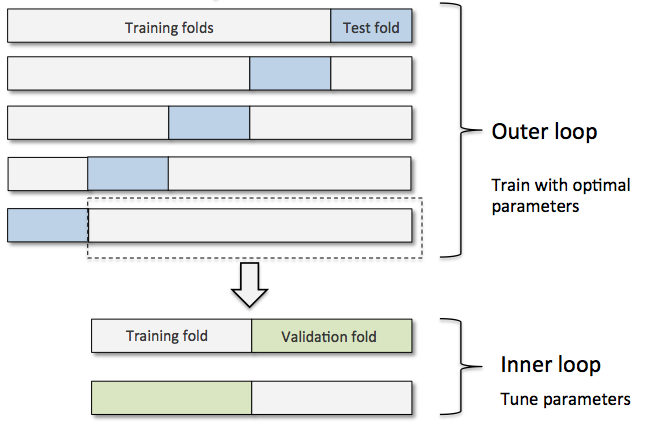

[4] https://sebastianraschka.com/faq/docs/evaluate-a-model.html

#### Adding the function for ROC_AUC plot

In [79]:
def plot_ROC_PRC(fpr_total, tpr_total, recall_total, precision_total, sampling):
    
    ## Firt plot is for ROC
    tprs = []
    aucs = []
    import matplotlib.pyplot as plt
    import numpy as np
    mean_fpr = np.linspace(0, 1, 200)
    plt.figure(figsize=(25,10))
    
    i = 0
    plt.subplot(1,2,1)
    # from scipy import interp
    from numpy import interp
    for j in range(len(fpr_total)):
        fpr = fpr_total[j]
        tpr = tpr_total[j]
        tprs.append(interp(mean_fpr, fpr, tpr))
        #tprs.append(tpr)
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        #roc_auc = auc(fpr, interp(mean_fpr, fpr, tpr))
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=3, alpha=0.5, label='Outer loop %d (ROC_AUC = %0.2f)' % (i+1, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
                 label='chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
#     mean_tpr[-1] = 1.0
    #mean_auc = auc(mean_fpr, mean_tpr)
    aucs = np.round(aucs,2)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    conf_int = 1.96*std_auc/np.sqrt(len(aucs))
    plt.plot(mean_fpr, mean_tpr, color='navy',
             label=r'Mean ROC_AUC = %0.2f $\pm$ %0.2f' % (mean_auc, conf_int),
             lw=4)

    std_tpr = np.std(tprs, axis=0)
#     tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#     tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.4,
#                      label=r'$\pm$ 1 Standard Deviation')
    plt.title('RF ROC curve with {}'.format(sampling) ,fontsize=15)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity' ,  fontweight = "bold" , fontsize=15)
    plt.ylabel('Sensitivity',fontweight = "bold" , fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.legend( prop={'size':15} , loc = 4)
    plt.grid(True)
    # plt.savefig('RF_ROC_pilot.png', layout = 'tight')
    
 
    #plt.savefig(os.path.join(folder, 'ROC_PRC_corr_cutoff_{}.png'.format(corr_cutoff)))
    

      # 2nd plot is precision recall curve
    from numpy import interp
    prs = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)
    import numpy as np
    #     plt.figure(figsize=(8,6))
    plt.subplot(1,2,2)
    i = 0
    for r in range(len(recall_total)):

        precision = precision_total[r]
        recall =recall_total[r]
        prs.append(interp(mean_recall, precision, recall))
#         prs[-1][0] =0
        pr_auc = auc(recall, precision)
        aucs.append(pr_auc)
        plt.plot(recall, precision, lw=3, alpha=0.5, label='Outer loop %d (PR_AUC = %0.2f)' % (i+1, pr_auc))
        i += 1

    #plt.plot([0, 1], [1, 0], linestyle='--', lw=3, color='k', label='Luck', alpha=.8)
#     mean_precision = np.mean(prs, axis=0)
#     print(prs)
    mean_precision = np.mean(prs, axis=0)
    #mean_auc = auc(mean_recall,mean_precision )
    aucs = np.round(aucs,2)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    conf_int= 1.96*std_auc/np.sqrt(len(aucs))
    plt.plot(mean_precision, mean_recall,  color='navy',
             label=r'Mean PR_AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, conf_int),
             lw=4)

    plt.title('RF Precision Recall curve with {}'.format(sampling), fontsize=15)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall (Sensitivity)' ,  fontweight = "bold" , fontsize=15)
    plt.ylabel('Precision',fontweight = "bold" , fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.legend( prop={'size':15} , loc = 0)
    plt.grid(True)
    #plt.savefig(os.path.join('ROC_PRC'+s+'.png'))


Fitting 5 folds for each of 192 candidates, totalling 960 fits


C:\Users\Debraj\anaconda3\envs\env_ebm\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Fitting 5 folds for each of 192 candidates, totalling 960 fits


C:\Users\Debraj\anaconda3\envs\env_ebm\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Fitting 5 folds for each of 192 candidates, totalling 960 fits


C:\Users\Debraj\anaconda3\envs\env_ebm\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Fitting 5 folds for each of 192 candidates, totalling 960 fits


C:\Users\Debraj\anaconda3\envs\env_ebm\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



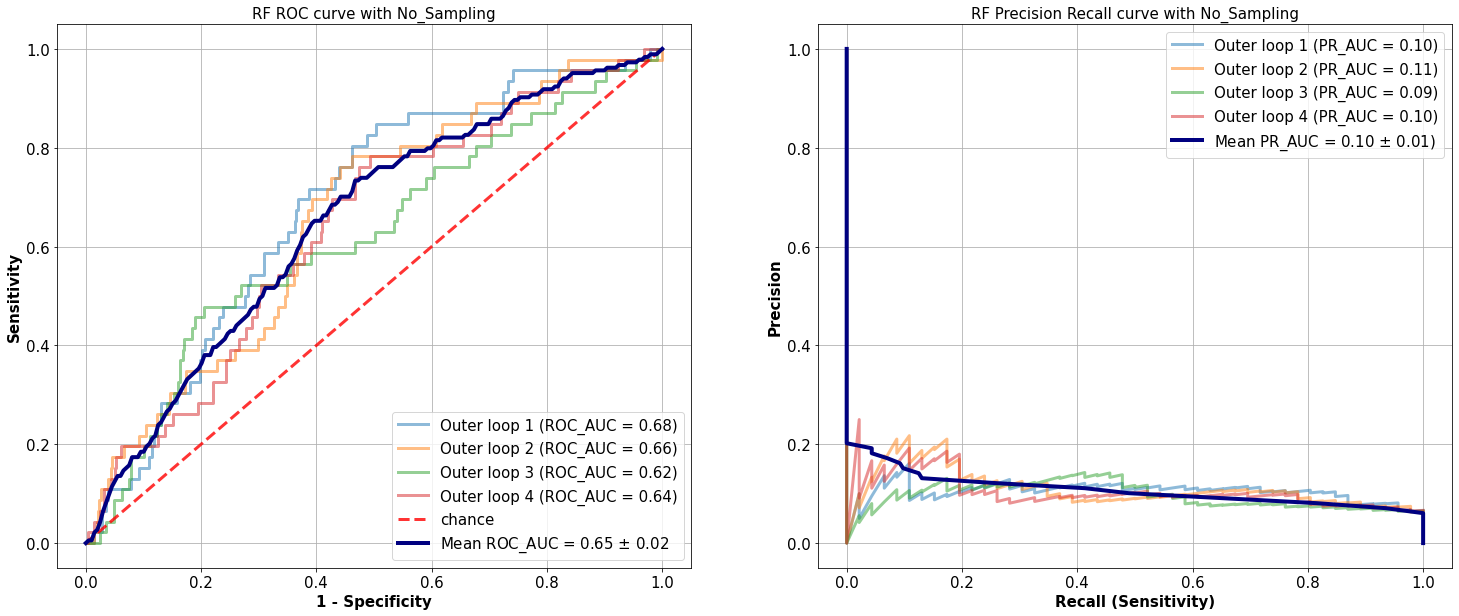

In [80]:
#### Cross validation using grid-search method will remove the need for splitting the samples into train, validation and test sets
#separately
from numpy import interp
from datetime import datetime
from sklearn.model_selection import train_test_split
import numpy as np
import random
import os
random_state = np.random.RandomState(42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc 
#Choose from any scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,  make_scorer, precision_score, recall_score, \
average_precision_score, accuracy_score, average_precision_score
from sklearn.metrics import roc_curve, auc  , precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import random
import seaborn as sns
#from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
#Scale the data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# # apply same transformation to test data
# X_test = scaler.transform(X_test)
from sklearn import metrics
from scipy.stats import ks_2samp
import numpy as np
from datetime import datetime
import pandas as pd
from sklearn.pipeline import Pipeline as nosampling_pipeline
#from imblearn.pipeline import Pipeline as imba_pipeline_up
# number of trees
n_estimators = [100,200, 500]
    # maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = [10, 20]
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

param_grid = {
    'bootstrap': [True],
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': [5,10],
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'criterion' : criterion  
}
hyperparameters = {'rf_model__' + key: param_grid[key] for key in param_grid}
scoring = {'roc_auc':make_scorer(roc_auc_score, needs_proba= True)}
finalResult = pd.DataFrame()
# scoring_outercv= {'roc_auc':make_scorer(roc_auc_score, needs_proba= True), 'precision': 'precision', 'recall': 'recall',\
#                  'accuracy': 'accuracy','prc_auc': make_scorer(average_precision_score,needs_proba=True),\
#                   'tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), \
#                   'fn': make_scorer(fn) , 'specificity': make_scorer(specificity)}
column_mean =['accuracy (%)', 'roc_auc','precision', 'sensitivity','specificity','prc_auc']
column_CI = list(r + ' 95% CI' for r in column_mean)

#exp_pipe = Pipeline([ ('scaler', StandardScaler()),('logreg', LogisticRegression(max_iter= 5000))])
column_list =[]

# df_cohort = pd.read_csv(data_file)
# Features = ['age', 'gender', 'weight', 'SysABP', 'DiasABP', 'HR', 'Temp','RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets']
# ### Defining feature set
# X = df_cohort[Features]
# from sklearn.preprocessing import OneHotEncoder
# ## Converting categorcial 'gender' using onehot encoding
# oe_style = OneHotEncoder(drop= 'first')
# oe_results = oe_style.fit_transform(X['gender'].values.reshape(-1,1))
# df_gender = pd.DataFrame(oe_results.toarray(), columns=['Male'])
# X = pd.concat([X, df_gender], axis =1)
# X.drop(columns ='gender', inplace = True)
### Target
y = df_cohort['label'].values


df_all= pd.DataFrame()
result =[]
fpr_total =[]
tpr_total =[]
precision_total =[]
recall_total =[]
Total_foldfeatureImportance = pd.DataFrame()
Number_holdout = 5 ## number of times we iterate to create a holdout set for testing
# sampling_strategy =['No_Sampling', 'Upsampling']
sampling_strategy =['No_Sampling']

for s in sampling_strategy:
    result =[]
    fpr_total =[]
    tpr_total =[]
    precision_total =[]
    recall_total =[]
    Total_foldfeatureImportance = pd.DataFrame()
    for r in range(1,Number_holdout) : # data set splitting


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r, stratify=y)
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


        startTime = datetime.now()
        rf_model=RandomForestClassifier(random_state=1)
        if s == 'No_Sampling':
            estimator = nosampling_pipeline([('rf_model', rf_model)])
        else :
            estimator = imba_pipeline_up([('sampling', SMOTE(sampling_strategy = 'minority',random_state=42)),\
                                 ('rf_model', rf_model)])

        clf = GridSearchCV(estimator=estimator, param_grid= hyperparameters, verbose =2,cv=inner_cv, scoring= scoring, refit = 'roc_auc', n_jobs=-1)
        best_model = clf.fit(X_train, y_train)

        rf = best_model.best_estimator_
        rf.fit(X_train, y_train)
        
        if s == 'No_Sampling':
            feature_importances = pd.DataFrame(rf[0].feature_importances_,index = X.columns,\
                               columns=['importance']).sort_values('importance',ascending=False)
        
        else: feature_importances = pd.DataFrame(rf[1].feature_importances_,index = X.columns,\
                               columns=['importance']).sort_values('importance',ascending=False)
        Y_pred = rf.predict(X_test)
        probas_=rf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1]) 
        ## Getting the tpr and fpr 
        tpr_total.append(tpr)
        tpr_total[-1][0] = 0.0
        fpr_total.append(fpr)
        #roc_auc = auc(fpr, tpr)

        ## getting the precision and recall
        precision, recall, _ = precision_recall_curve(y_test, probas_[:, 1])
        precision_total.append(precision)
        recall_total.append(recall)

    #     print(classification_report(y_test,Y_pred))
        tn = confusion_matrix(y_test, Y_pred)[0, 0]
        fp= confusion_matrix(y_test, Y_pred)[0, 1]
        fn= confusion_matrix(y_test, Y_pred)[1, 0]
        tp= confusion_matrix(y_test, Y_pred)[1, 1]

        data = [ 100*(accuracy_score(y_test, Y_pred)),  roc_auc_score(y_test, probas_[:, 1]), precision_score(y_test, Y_pred),\
                 recall_score(y_test, Y_pred), tn/(tn + fp)  , auc(recall, precision) ]
        data = np.round(data,2)
        result.append(data)
        endtime= datetime.now()
        feature_importances.reset_index(inplace = True)
        Total_foldfeatureImportance = pd.concat([Total_foldfeatureImportance, feature_importances], axis =1 )
    df_results  =  pd.DataFrame(pd.DataFrame(result).mean()).transpose()
    df_results.columns =column_mean
    ci_df = pd.DataFrame(np.round(1.96*pd.DataFrame(result).std(ddof=0)/np.sqrt(Number_holdout-1),2)).transpose()
    ci_df.columns = column_CI
    Final_result = pd.concat([df_results, ci_df], axis =1)
    Final_result.insert(0,'Duration into hospitalization', N_hour)


    plot_ROC_PRC(fpr_total, tpr_total, recall_total, precision_total,s)
    Final_result.to_csv('ML_results_'+ s + '.csv', mode = 'a')
    Total_foldfeatureImportance.to_csv('FeatureImportance' + s + '.csv', mode = 'a')

In [31]:
Final_result

,Duration into hospitalization,accuracy (%),roc_auc,precision,sensitivity,specificity,prc_auc,accuracy (%) 95% CI,roc_auc 95% CI,precision 95% CI,sensitivity 95% CI,specificity 95% CI,prc_auc 95% CI
0,12,93.58,0.65,0.0,0.0,1.0,0.1,0.0,0.02,0.0,0.0,0.0,0.01


In [64]:
df_cohort['Duration before ARDS (hours)'].max()

508.85

#### Result interpretation
The ROC_AUC curve is over 0.5 but not in the good performing region of more than 0.85. The reason can be that we have very few postive examples as compared to negative examples. That has significantly biased the model to learn from negative examples and limited learning from postive examples. 

Also, we are predicting the results, we are using data upto 12 hours into admission to predict ARDS far in future (upto 508 hours). 
In 12 hours- admission prediction to ARDS has 3578 examples with 3346 and 232 negative and positive instances respectively.

When we predicted ARDS while in hospital for 24 hours or more, the ROC_AUC marginally improve from 0.65 to 0.71. 
In 24 hour admission prediction of ARDS, , we have 2126 examples with 1980 and 146 negative and positive instances respectively.

To be noted, the ratio of positive and negative examples in both the cases are the same.

Lastly, we need to try few more models to compare performances.

#### Interpretability using Feature importance of Random Forest

The feature importance calcultions show the importance score of each features in predicting ARDS. In each of the 4 iterations, the ranking has been quite consistent. However, these ranking does not tell us how the values of these features affect the ARDS prediction outcome. For example, SpO2 has a high ranking but we dont know from the feature importance score if high SpO2 is an indication of ARDS or not. The complex interaction between the features can be explained by model free interpretable tools like LIME and SHAP (SHapley Additive exPlanations) has been used. In this project, SHAP has been used.

In [33]:
Total_foldfeatureImportance

,index,importance,index,importance,index,importance,index,importance
0,RespRate,0.141050,RespRate,0.165628,RespRate,0.148680,RespRate,0.157284
1,SpO2,0.135898,SpO2,0.113584,SpO2,0.122189,SpO2,0.127850
2,SysABP,0.096318,SysABP,0.108979,SysABP,0.109315,SysABP,0.105682
3,HR,0.094027,HR,0.095734,Temp,0.087686,DiasABP,0.087206
4,Temp,0.087022,DiasABP,0.081945,HR,0.084535,weight,0.083287
5,weight,0.082741,Temp,0.081895,weight,0.079558,HR,0.080047
6,DiasABP,0.079316,Platelets,0.079349,Platelets,0.078087,Temp,0.076757
7,Platelets,0.073900,weight,0.078656,DiasABP,0.077005,Platelets,0.076204
8,WBC,0.071040,WBC,0.066944,WBC,0.073518,WBC,0.075805
9,age,0.064832,age,0.061004,age,0.064366,Creatinine,0.060399


#### Using model free interpretability tools
SHAP (SHapley Additive exPlanations) by Lundberg and Lee (2016)48 is a method to explain individual predictions. SHAP is based on the game theoretically optimal Shapley Values.
[5] https://christophm.github.io/interpretable-ml-book/shapley.html


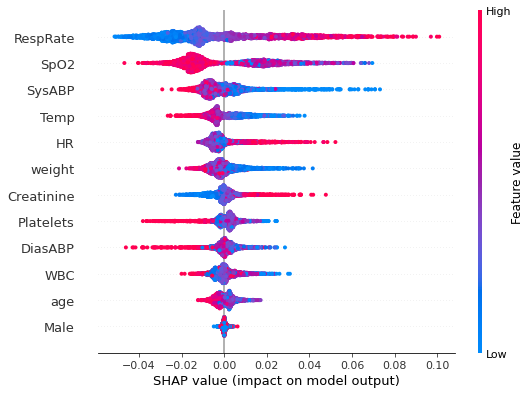

In [81]:
import shap
#shap.initjs()
# Let us have a look on SHAP summary plot
samples = X_train
# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(rf[0])

shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

shap.summary_plot(shap_values[1], samples)

### Summary plot analysis: Interpretable model analysis
#### Result with no upsampling of minority classes
#### observations
- the most important feature of the model on the y-axis in a descending order (at the top the most important one).
- the SHAP value on the x-axis.
- the feature value with colors. A high value is represented with red, while a low value with blue.

We can see that Respiratory rate, SpO2 and SysABP are the top 3 features that contribute to the prediction. It corroborates with our finding of feature ranking from random forest results.

The current plot also shows that higher respiratory rate is related to higher chance of ARDS. It also supports the general knowledge of the Healthcare science that have listed rapi breathing as one sign of ARDS. 

[6] https://www.nationaljewish.org/conditions/ards-acute-respiratory-distress-syndrome/signs-symptoms

Sp02 or oxygen level in blood is likely going to be affected when a patient has ARDS. The summary plot shows that low SpO2 can be linked to ARDS. Also low systolic blood pressure is indicative of ARDS as suggested in the SHAP summary plot. This observation is also well supported in literature. 

[7] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4181226/

The summary plot gives us a global view of the features and how they interact with each other.

#### Using Boosting model
The most widely used boosting model is the XGBOOST (using gridsearch to find the set of parameters that optimizes the AUC-ROC)

In [ ]:
#### Cross validation using grid-search method will remove the need for splitting the samples into train, validation and test sets
#separately
from numpy import interp
from datetime import datetime
from sklearn.model_selection import train_test_split
import numpy as np
import random
import os
random_state = np.random.RandomState(42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc 
#Choose from any scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,  make_scorer, precision_score, recall_score, \
average_precision_score, accuracy_score, average_precision_score
from sklearn.metrics import roc_curve, auc  , precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import random
import seaborn as sns
#from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
import xgboost as xgboost
#Scale the data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# # apply same transformation to test data
# X_test = scaler.transform(X_test)
from sklearn import metrics
from scipy.stats import ks_2samp
import numpy as np
from datetime import datetime
import pandas as pd
from sklearn.pipeline import Pipeline as nosampling_pipeline
#from imblearn.pipeline import Pipeline as imba_pipeline_up
import xgboost as xgb
import sklearn as skl
print("Training XGB model...")  
x_train = df_cohort[Features].to_numpy()
y_train = df_cohort['label'].values

y_train = np.array(y_train).astype(int)

print(len(x_train), len(y_train), y_train.sum())

num_pos = np.sum(y_train)
num_neg = np.sum(y_train==0)

print('num pos', num_pos)
print('num neg', num_neg )

neg_pos_ratio = num_neg//num_pos
print(neg_pos_ratio)
# number of trees
parameter_grid = {
        'max_depth': [2, 3, 4],
        'learning_rate': [0.001, 0.01, 0.1],
        'gamma': [1.5, 2.5],
        'reg_lambda': [2,  3],
        'colsample_bytree': [0.1, 0.2, 0.3],
        'n_estimators': [50, 100],
    }
kfold = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
xgb_model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=True)
search_clf = skl.model_selection.GridSearchCV(xgb_model, 
                                                    parameter_grid, 
                                                    scoring = 'roc_auc', 
                                                    cv = kfold, 
                                                    refit = False, 
                                                    verbose = 2,
                                                    n_jobs = -1)
search_clf.fit(x_train, y_train.reshape(-1,))
best_params = search_clf.best_params_
       
print(best_params, search_clf.best_score_)


In [ ]:
search_clf.cv_results_

#### Explainable boosting machine


In [49]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
X = df_cohort[Features]
y = df_cohort['label'].values

seed = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

ebm = ExplainableBoostingClassifier(random_state=seed)
ebm.fit(X_train, y_train)

ebm_global = ebm.explain_global()
show(ebm_global)

ebm_local = ebm.explain_local(X_test[:5], y_test[:5])
show(ebm_local)

In [54]:
## testing the results
y_prob = ebm.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1]) 

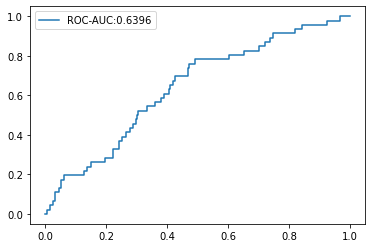

In [89]:
plt.plot(fpr, tpr, label = 'ROC-AUC:{}'.format(np.round(auc(fpr, tpr),4)))
plt.legend()
## The result will vary depending on the random seed 

### Project on regression (Forecasting) model development

4 models to develop using real world patient admission details.

- Prediction of the number of new Covid admissions today (index date + 1 day)
- Prediction of the number of new Covid admissions tomorrow (index date + 2 days)
- Prediction of the number of Covid patients still in the hospital at the end of today (index date + 1 day)
- Prediction of the number of Covid patients still in the hospital at the end of tomorrow (index date + 2 days)

### Time Series to a Supervised Learning Problem

- Time Series to a Supervised Learning Problem
- Before machine learning can be used, time series forecasting problems must be re-framed as supervised learning problems

- From a sequence to pairs of input and output sequences
- Current values are dependent on the past values

A supervised learning problem is comprised of input patterns (X) and output patterns (y), such that an algorithm can learn how to predict the output patterns from the input patterns
- Use lagged observations (e.g. t-1, t-2 etc.) as input variables to forecast the current time step (t)
 #### What lag vale to use?
Use Partial autocorrelation function (PACF)

#### Use of machine learning (ML) regressor model for prediction

- Time series analysis has different challenges 
- Can not be treated like another classical ML model
- it would not be valid to fit the model on data from the future and have it predicted the past. 
- The model must be trained on the past and predict the future
- This means that methods that randomize the dataset during evaluation, like k-fold cross-validation, cannot be used

####  We must use a technique called walk-forward validation

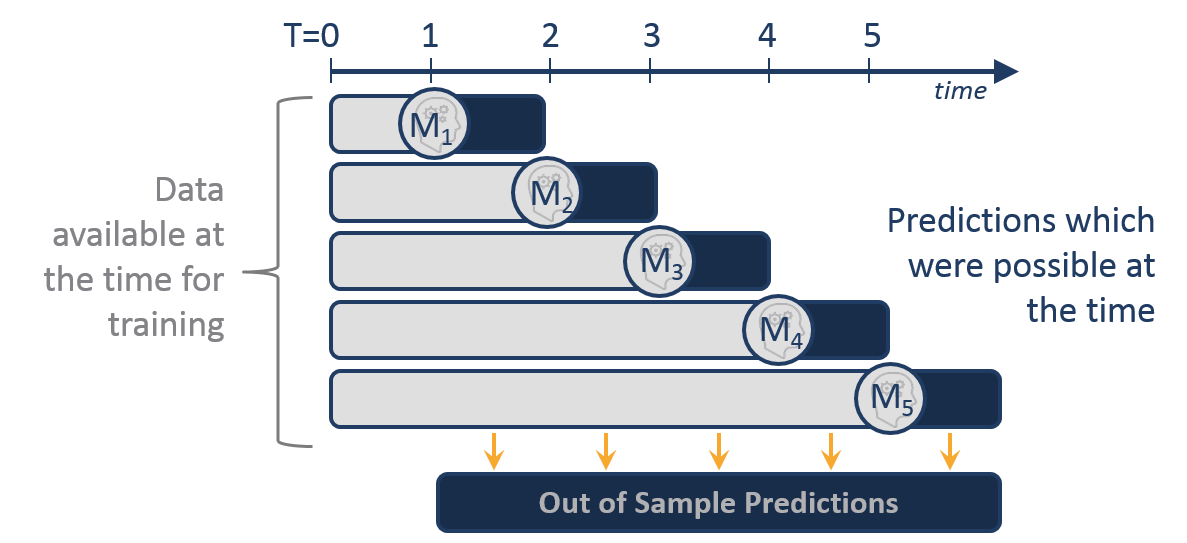


[5] https://alphascientist.com/walk_forward_model_building.html

#### why the project is interesting
- The model outcome can help optimize hospitals reallocate resources
- Sicne the trend and seasonality is not known for Covid 19 surge, traditional statistical methods are not very effective.
- Prediction model predicted the point values and the 90% confidence interval (5% and 95% quantile regression)
- Used Gradient Boost regressor for model development
- Challenges ahead: determine the size of the walk forward cross validation folds, how far should we go back to build the regression models.
- Most important for me !!! Learned new things, applied to real world problems and got pretty good results


